In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import pylab as plt

import numpy as np
import matplotlib.pyplot as plt

# local imports
from util.ellipse import plot_ellipse
from doubly_AIS import DAIS

In [2]:
# below define the target distribution and its gradient
dim = 2
SD_TARGET = 0.1

def func(x):
    return 1.+jnp.sin(2*x)

@jax.jit
def log_target_density(z):
    x,y = z[0], z[1]
    return -0.5*x**2 - 0.5*(y - func(x))**2/SD_TARGET**2

log_target_density = jax.jit(log_target_density)
log_target_density_batch = jax.jit(jax.vmap(log_target_density))

def generate_target(S):
    """ generate iid samples from the target distribution """
    x = np.random.normal(0,1,S)
    y = func(x) + SD_TARGET*np.random.normal(0,1,S)
    return np.concatenate([x[:,None], y[:,None]], axis=1)

In [3]:
# compute empirical mean // covariance from iid sampled
S = 10**6
xs = generate_target(S)
print(xs.shape)
mu_target = np.mean(xs, axis=0)
# compute empirical covariance
Gamma_target = np.cov(xs, rowvar=False)


(1000000, 2)


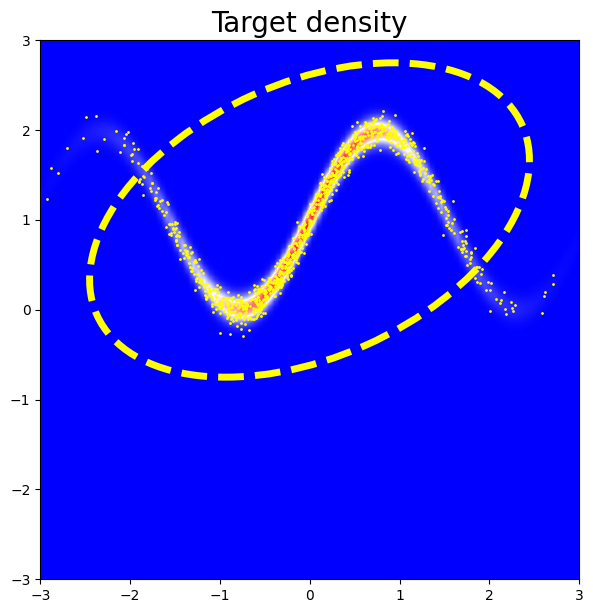

In [4]:
# plot the target distribution
mx, Mx = -3,3
my, My = -3,3
N = 100
X0,X1 = np.meshgrid(
            np.linspace(mx,Mx ,N),
            np.linspace(my,My,N),
            )
X = np.concatenate([X0[:,:,None], X1[:,:,None]], axis=2)
Z = log_target_density_batch(X.reshape(N**2,-1))
Z = np.exp(Z.reshape(N,N))

fig, ax = plt.subplots(1, 1, figsize=(7,7))

# plot density
plt.imshow(Z, origin="lower", interpolation="bilinear", 
           extent=[mx,Mx,my,My], cmap="bwr")

# plot samples
N_to_plot = 1000
plt.scatter(xs[:N_to_plot,0], xs[:N_to_plot,1], s=1, color="yellow")
plt.xlim(mx,Mx)
plt.ylim(my,My)

plt.title("Target density", fontsize=20)

plot_ellipse(ax, mu_target, Gamma_target,
             color="yellow", linestyle="--", lw=5)

In [5]:
## Run DAIS:

# initial mean/covariance
mu_init = np.zeros(dim)
Gamma_init = np.eye(dim)

# damping parameter
alpha_damp = 0.1

# number of smaples and number of iterations
n_samples = 10000
n_iter = 50

# Effective Sample size threshold
ESS_threshold = 0.1
save_history = True
    
# run DAIS:
output_dict = DAIS(
                log_target = log_target_density,
                mu_init = mu_init,
                Gamma_init = Gamma_init,
                n_samples = n_samples,
                n_iter = n_iter,
                alpha_damp = alpha_damp,
                ESS_threshold = ESS_threshold,
                save_history=save_history,
                )

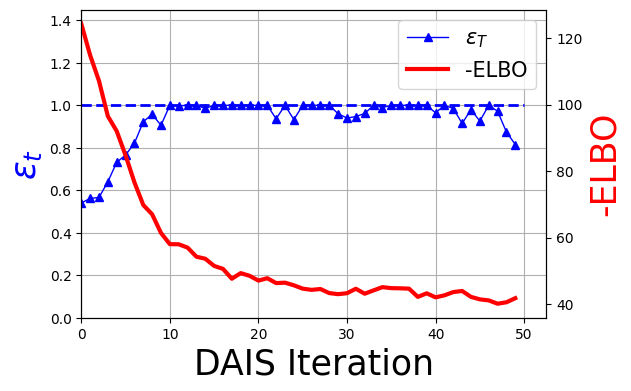

In [6]:
fig, ax_left = plt.subplots(figsize=(6,4))
ax_right = ax_left.twinx()

p1 = ax_left.plot(output_dict["eps_traj"], "-^", lw=1, color='blue', label=r"$\epsilon_T$")
ax_left.plot([0, len(output_dict["eps_traj"])], [1,1], "--", lw=2, color='blue')
ax_left.set_ylim(0,1.45)
ax_left.set_xlim(left=0)
ax_left.set_ylabel(r"$\epsilon_t$", fontsize=25, color="blue")
ax_left.set_xlabel("DAIS Iteration", fontsize=25)

ax_left.grid(True, which="major")



p2 = ax_right.plot(-np.array(output_dict["ELBO_traj"]),
                   color='red', label="-ELBO", lw=3)
ax_right.set_ylabel("-ELBO", fontsize=25, color="red")


# added these three lines
lns = p1+p2
labs = [l.get_label() for l in lns]
ax_left.legend(lns, labs, loc=1, fontsize=25)


# added these three lines
lns = p1+p2
labs = [l.get_label() for l in lns]
ax_left.legend(lns, labs, loc=1, fontsize=15)

plt.savefig("banana_monitor.pdf", dpi=200, bbox_inches='tight')

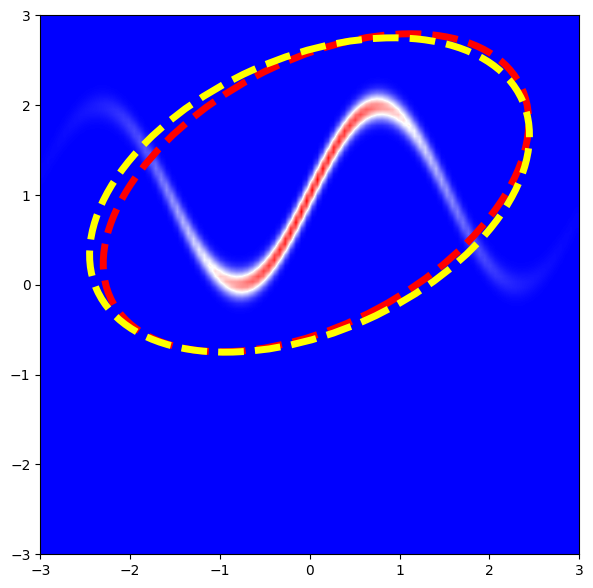

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.imshow(Z, origin="lower",
          interpolation="bilinear",
          extent=[mx,Mx,my,My],
          cmap="bwr")

mu = output_dict["mu"]
Gamma = output_dict["Gamma"]
plot_ellipse(ax, mu, Gamma, color="red", linestyle="--", lw=5)
plot_ellipse(ax, mu_target, Gamma_target, color="yellow", linestyle="--", lw=5)